In [1]:
from flowjax.train.data_fit import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.flows import masked_autoregressive_flow as MaskedAutoregressiveFlow
from flowjax.distributions import Normal, Laplace
import flowjax.bijections as bij
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np
from sklearn.preprocessing import StandardScaler
from jax import vmap
import pandas as pd
import json
import pickle
import scipy

In [3]:
#observed data
filename = "../simulation/observed_data/observed_stats.csv"
x_o = pd.read_csv(filename)
#simulated data
filename2 = "../simulation/output/round_1/summary_stats_r1.csv"
x = pd.read_csv(filename2)
#params for simulations
filename3 = "../simulation/output/round_1/thetas_r1.csv"
theta = jnp.array(np.genfromtxt(filename3, delimiter=',', dtype=float))

In [4]:
to_drop = [#correlation >0.99
    "y1_domestic",
    "y1_scot",
    "y1_captive",
    "y1_eu",
    "y1_lyb",
    "y3_domestic_captive_lyb",
    "divergence_domestic_eu",
    "y3_domestic_scot_lyb",
    "y3_domestic_eu_lyb",
    "divergence_captive_lyb",
    "segregating_sites_lyb",
    "segregating_sites_eu",
    "divergence_scot_lyb",
    "f4_domestic_scot_captive_lyb",
    "f4_domestic_captive_eu_lyb",
    "f4_domestic_scot_eu_lyb",
    "diversity_domestic",
    "y3_domestic_scot_captive",
    "y3_scot_captive_eu",
    "f2_domestic_eu",
    "y2_domestic_lyb",
    "y3_scot_captive_lyb",
    "divergence_captive_eu",
    "pc1_dist_domestic_eu",
    # outlier noise model method r1 (>1)
    'tajimas_d_eu',
    'relatedness_domestic_lyb',
    'pc1_iqr_domestic',
    'pc1_iqr_eu',
    'pc1_iqr_lyb',
    'pc2_iqr_domestic',
    'pc2_iqr_lyb',
    # outlier noise model method r2 (>0.8)
    'relatedness_captive_lyb',
    'pc1_median_eu',
    'pc2_dist_domestic_lyb',
    # drop_one algorithm, achieved 0.7788 hdr
    'pc2_iqr_eu',
    'relatedness_domestic_eu',
    'tajimas_d_lyb',
    'pc1_dist_captive_eu',
    'fst_scot_lyb',
    'pc2_iqr_scot',
    'pc1_dist_scot_lyb',
    'pc1_dist_eu_lyb']

In [5]:
combined_x = pd.concat([x, x_o], ignore_index=True)
combined_x = combined_x.drop(columns=to_drop)
stats = combined_x.columns
combined_x = combined_x.to_numpy(dtype=np.float32)
np.shape(combined_x)

(10001, 93)

In [6]:
#normalise data
x_scaler = StandardScaler()
print("combined_x shape", np.shape(combined_x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = np.float32(combined_x_t[0:10000])
x_o_t = np.float32(combined_x_t[10000])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 93)
x_t shape (10000, 93)
x_o_t shape (1, 93)


In [7]:
theta = theta[1:10001]
log_theta = jnp.log(theta)
theta_scaler = StandardScaler()
theta_t = theta_scaler.fit_transform(log_theta)
print("theta_t shape", np.shape(theta_t))

theta_t shape (10000, 16)


In [8]:
# save scaler models
with open('./sequential_files/x_scaler.pkl','wb') as f:
    pickle.dump(x_scaler, f)
    
with open('./sequential_files/theta_scaler.pkl','wb') as f:
    pickle.dump(theta_scaler, f)

In [ ]:
with open('./sequential_files/x_scaler.pkl','rb') as f:
    x_scaler = pickle.load(f)

print("combined_x shape", np.shape(combined_x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = np.float32(combined_x_t[0:9914])
x_o_t = np.float32(combined_x_t[9914])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

In [ ]:
with open('./sequential_files/theta_scaler.pkl','rb') as f:
    theta_scaler = pickle.load(f)

theta = theta[1:9915]
log_theta = jnp.log(theta)
theta_t = theta_scaler.fit_transform(log_theta)
print("theta_t shape", np.shape(theta_t))

In [9]:
key, subkey = jr.split(jr.PRNGKey(2))
#define prior
unbounded_prior = Normal(jnp.zeros(16))

In [10]:
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros(16)),
    transformer=bij.Affine(),
    cond_dim=x_o_t.size,
)

In [121]:
#for sequential:
flow = eqx.tree_deserialise_leaves("./sequential_files/posterior_r1.eqx", flow)

In [11]:
import optax
optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-5),
    )

In [12]:
loss_fn = ContrastiveLoss(unbounded_prior, n_contrastive=10)

In [27]:
fitted_flow, losses_r = fit_to_data(
    key=subkey,
    dist=flow,
    loss_fn=loss_fn,
    x=theta_t,
    condition=x_t,
    max_epochs=2000,
    optimizer=optimizer,
    max_patience=15,
    batch_size=75
)

 16%|█▋        | 325/2000 [16:38<1:25:48,  3.07s/it, train=inf, val=inf (Max patience reached)]


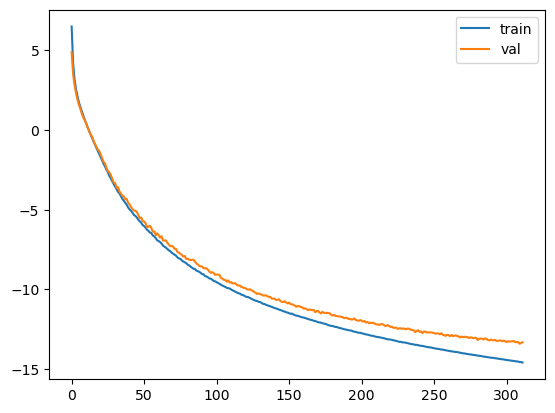

In [28]:
for k, v in losses_r.items():
    plt.plot(v, label=k)
plt.legend()
plt.savefig("./sequential_files/losses_r1.png")

In [17]:
# save proposal between rounds
model = fitted_flow

eqx.tree_serialise_leaves("./sequential_files/posterior_r1.eqx", model)

In [31]:
# save sample parameters for next round
posterior = fitted_flow
samples = posterior.sample(subkey, (10000,), condition=x_o_t)
print(np.shape(samples))
samples = np.reshape(samples, (10000,16))

(10000, 1, 16)


In [32]:
samples = theta_scaler.inverse_transform(samples)
theta_r2 = np.exp(samples)

In [29]:
np.shape(theta_r2)
tr2 = pd.DataFrame(theta_r2)
tr2.to_csv("./sequential_files/tr2.csv", index=False)

In [21]:
#parameter names for plots
names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

In [133]:
theta_3 = pd.read_csv("./previous/thetas_r3.csv")
theta_3 = theta_3.to_numpy(dtype=np.float32)
theta_2 = pd.read_csv("./previous/thetas_r2.csv")
theta_2 = theta_2.to_numpy(dtype=np.float32)
theta = pd.read_csv("./thetas_r1.csv")
np.shape(theta_2)

(10000, 16)

In [23]:
priors_dict = {
    "captive_time": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "div_time": scipy.stats.lognorm(s=0.7, loc=10000, scale=60000),
    "div_time_dom": scipy.stats.lognorm(s=0.5, loc=500, scale=3000),
    "div_time_scot": scipy.stats.lognorm(s=0.3, loc=0, scale=3000),
    "mig_rate_captive": scipy.stats.lognorm(s=1, loc=0, scale=0.07),
    "mig_rate_scot": scipy.stats.lognorm(s=1, loc=0, scale=0.07),
    "mig_length_scot": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "pop_size_captive": scipy.stats.lognorm(s=0.6, loc=0, scale=100),
    "pop_size_domestic_1": scipy.stats.lognorm(s=1, loc=0, scale=60000),
    "pop_size_lyb_1": scipy.stats.lognorm(s=1, loc=0, scale=20000),
    "pop_size_lyb_2": scipy.stats.lognorm(s=1.5, loc=5000, scale=100000),
    "pop_size_scot_1": scipy.stats.lognorm(s=1, loc=0, scale=4000),
    "pop_size_eu_1": scipy.stats.lognorm(s=1.3, loc=0, scale=20000),
    "pop_size_eu_2": scipy.stats.lognorm(s=1, loc=0, scale=60000),
    "mutation_rate": scipy.stats.lognorm(s=1, loc=0, scale=1e-8),
    "recombination_rate": scipy.stats.lognorm(s=0.5, loc=0.4e-8, scale=9e-9)
}

theta = []
for key, prior in priors_dict.items():
    theta.append(prior.rvs(10000))
theta = np.concatenate(theta, axis=0)
print(np.shape(theta))
theta = np.reshape(theta, (16,10000))
print(np.shape(theta))

(160000,)
(16, 10000)


In [24]:
params = {
    "captive_time": {"bins" : np.arange(0, 100, 1), "lims" : [0, 100]},
    "div_time": {"bins" : np.arange(0, 400000, 3000), "lims" : [0, 400000]},
    "div_time_dom": {"bins" : np.arange(500, 11000, 100), "lims" : [500, 11000]},
    "div_time_scot": {"bins" : np.arange(1000, 7000, 50), "lims" : [1000, 7000]},
    "mig_rate_captive": {"bins" : np.arange(0, 0.4, 0.005), "lims" : [0, 0.4]},
    "mig_rate_scot": {"bins" : np.arange(0, 0.3, 0.004), "lims" : [0, 0.3]},
    "mig_length_scot": {"bins" : np.arange(0, 80, 1), "lims" : [0, 80]},
    "pop_size_captive": {"bins" : np.arange(0, 500, 5), "lims" : [0, 500]},
    "pop_size_domestic_1": {"bins" : np.arange(0, 500000, 4000), "lims" : [0, 500000]},
    "pop_size_lyb_1": {"bins" : np.arange(0, 100000, 800), "lims" : [0, 100000]},
    "pop_size_lyb_2": {"bins" : np.arange(0, 750000, 5000), "lims" : [0, 750000]},
    "pop_size_scot_1": {"bins" : np.arange(0, 30000, 200), "lims" : [0, 30000]},
    "pop_size_eu_1": {"bins" : np.arange(0, 150000, 2000), "lims" : [0, 150000]},
    "pop_size_eu_2": {"bins" : np.arange(0, 250000, 2500), "lims" : [0, 250000]},
    "mutation_rate": {"bins" : np.arange(0, 0.6e-7, 0.6e-9), "lims" : [0, 0.6e-7]},
    "recombination_rate": {"bins" : np.arange(0.5e-8, 3.5e-8, 3e-10), "lims" : [0.5e-8, 3.5e-8]}
         }

names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

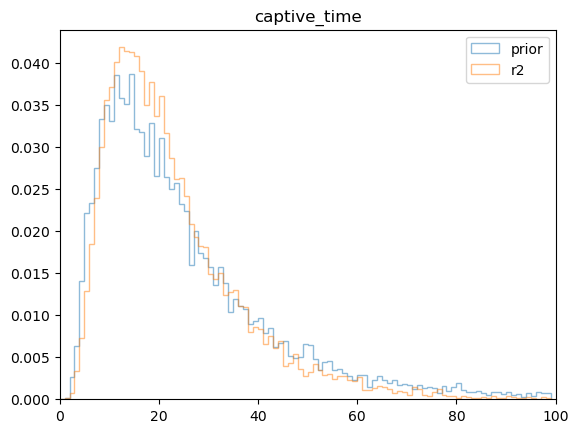

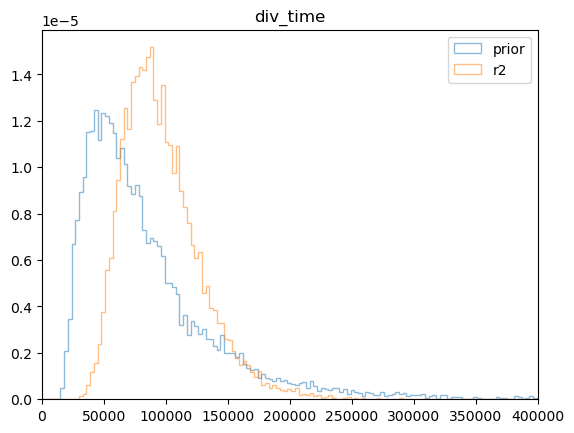

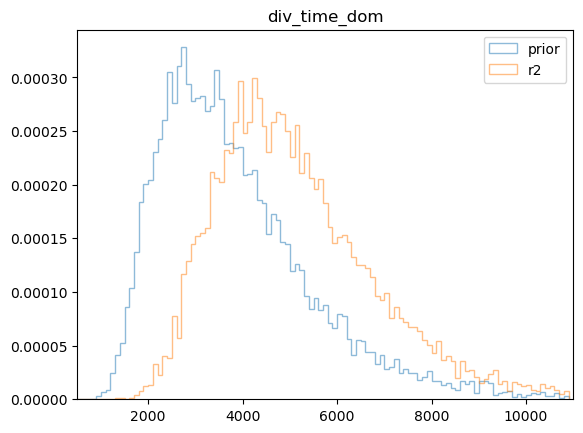

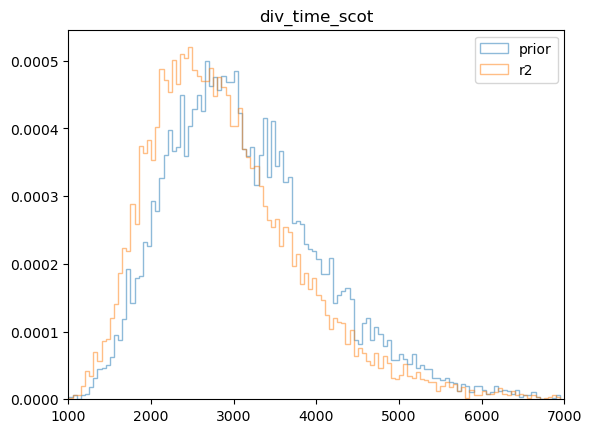

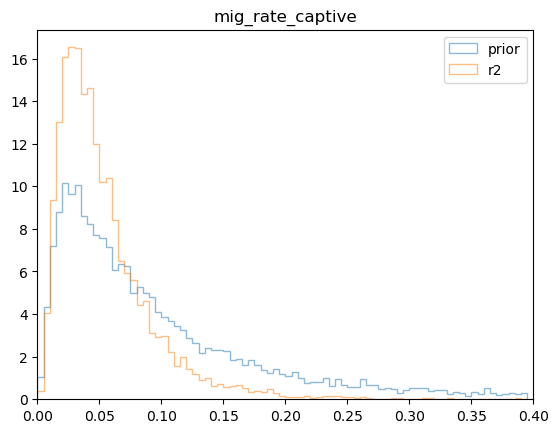

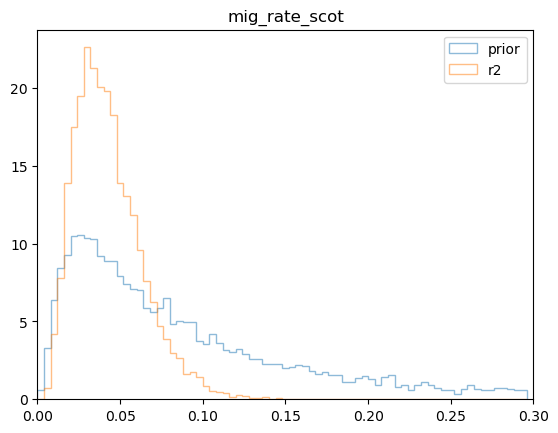

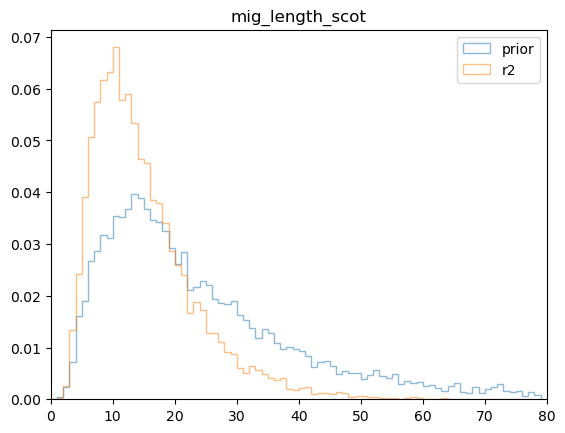

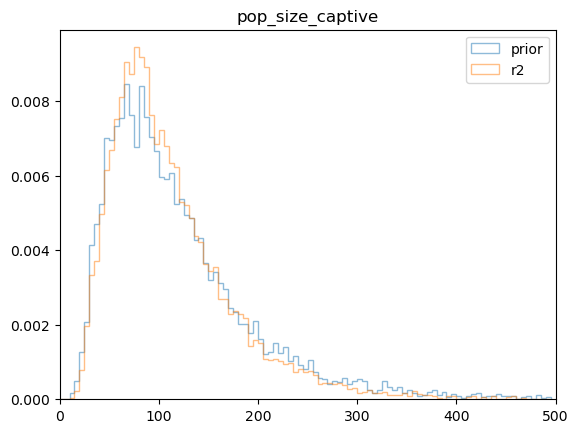

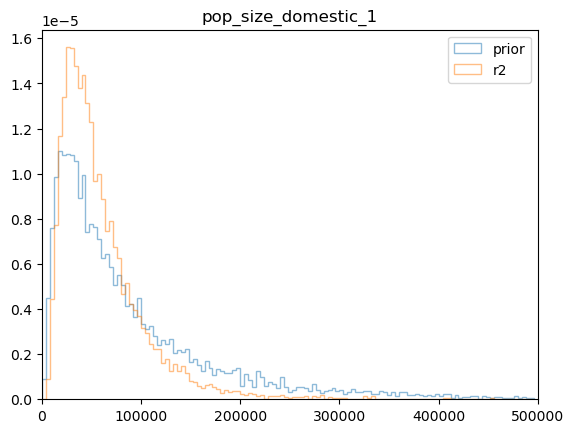

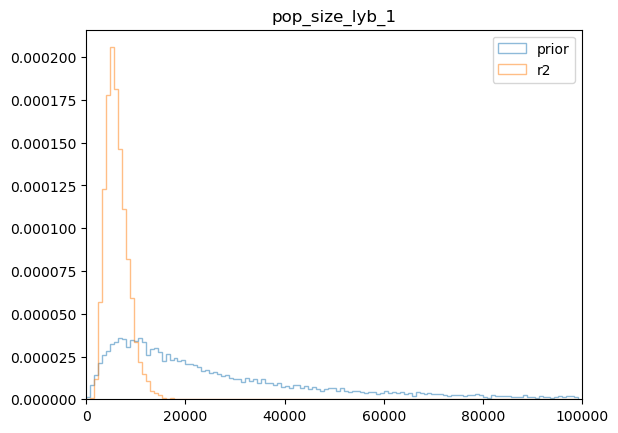

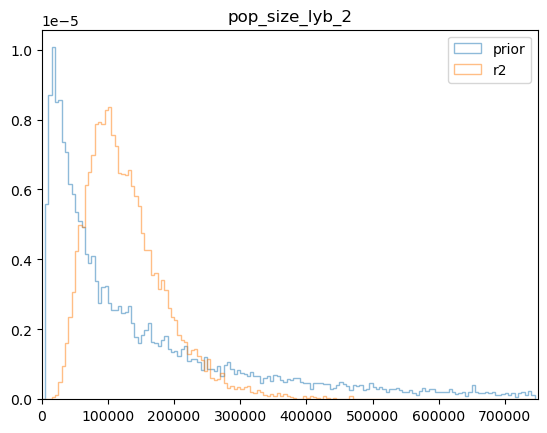

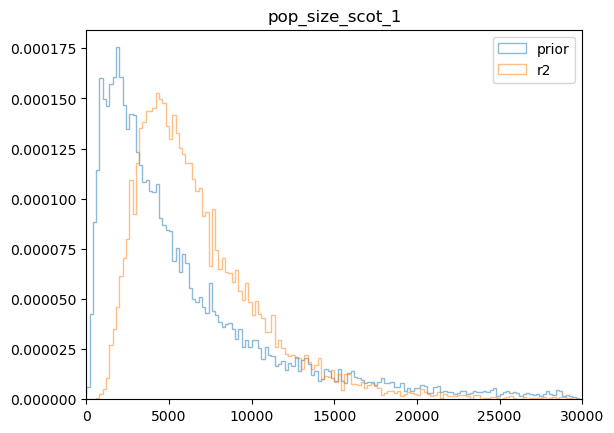

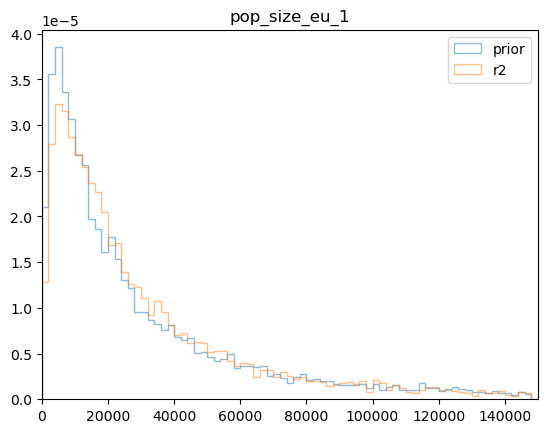

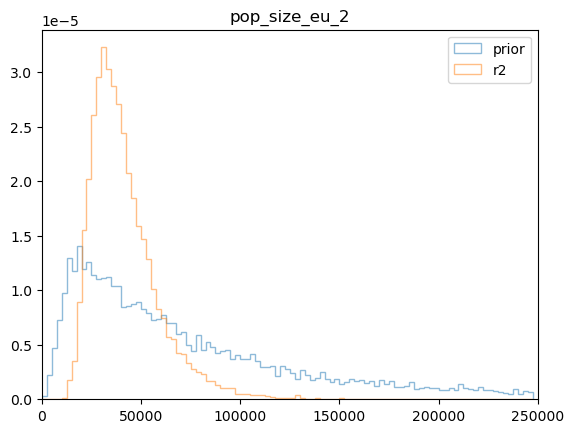

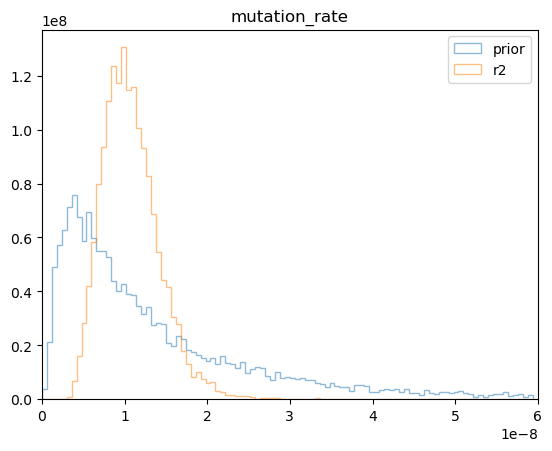

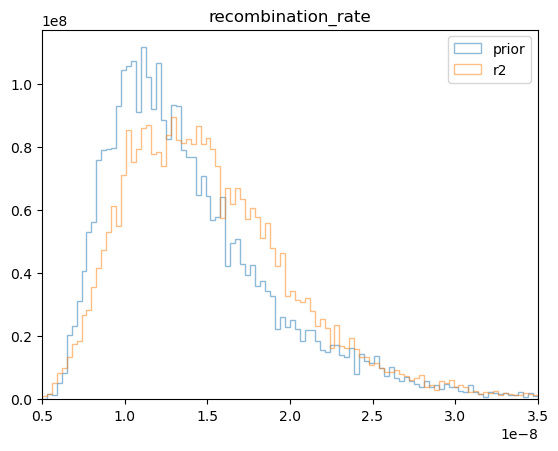

In [33]:
# plot parameter distributions
for num in range(0,16): 
    stat = names[num]
    
    plt.hist(theta[num][:],
             alpha=0.5,
             label='prior', bins=params[stat]["bins"], density=True, histtype='step')
    
    plt.hist(theta_r2[:,num],
             alpha=0.5,
             label='r2', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_3[:,num],
        #     alpha=0.5,
         #    label='r3', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_4[:,num],
         #    alpha=0.5,
         #    label='r4', bins=params[stat]["bins"], density=True, histtype='step')

    plt.legend(loc='upper right')
    plt.title(stat)
    #plt.yticks([])
    plt.xlim(params[stat]["lims"])
    plt.show()